# Action recognition with ST-GCN
---
This notebook is a translation and adaptation from https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/03_action_recognition_ST_GCN.ipynb.


# Motion recognition from skeletal data

---



###Skeletal data

In the context of using ST-GCN (Spatial Temporal Graph Convolutional Networks) for action recognition, skeletal data plays a crucial role. Initially, this data consists of the coordinates of various joints in the human body for each frame of the video. However, to effectively utilise this data within a GCN framework, we need to transform it from mere coordinates to a graph-based structure.

Here's how this transformation is accomplished:

1. **From Coordinates to Graph Structure:** While raw skeletal data starts as just coordinates, it gains depth and utility when we map it onto a graph structure. In this structure, the joints of the human body are represented as nodes in the graph, while the connections between these joints (such as the link between the elbow and the shoulder) are represented as edges.

2. **Understanding the Graph Representation:** By structuring skeletal data in this manner, we are able to more accurately represent the human form and its dynamics. This graph-based approach enables us to consider not just the position of individual joints, but also their interrelations and how they move in conjunction with one another.

3. **Leveraging Graph Convolutional Networks:** Once the skeletal data is represented as a graph, it is passed through Graph Convolutional Networks. GCNs are adept at processing graph-structured data and, in this context, they are used to identify and classify the actions being performed, based on the patterns and relationships identified within the skeletal graph.

4. **Visual Example:** The video below illustrates an example of skeletal data expressed as a graph. This visual representation helps in understanding how the individual joints (nodes) and their connections (edges) form a comprehensive structure, which is then analysed by the GCN to recognise various human actions.

By transforming skeletal data into a graph format and employing GCNs, we are able to harness the full potential of skeletal data in action recognition, enabling more accurate and nuanced interpretations of human movements.



<!--
<img src='https://drive.google.com/uc?id=1WrYd80u9buVcmBnpsgSZnzFlsYMih7Nr' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>

#Spatial Temporal Graph Convolutional Networks

---



Spatial Temporal Graph Convolutional Networks (ST-GCN) [[arXiv](https://arxiv.org/abs/1801.07455)] is a method for motion recognition from skeletal data using GCN.

<!--
<img src='https://drive.google.com/uc?id=1ZRf-NF4S0P1VwMxN2DrTFPeO4EJ5if3S' width=100%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>

A notable aspect of ST-GCN (Spatial Temporal Graph Convolutional Networks) is its approach to representing skeletal data through dual graph structures:

* **Spatial Graph:** This graph connects the joints within the same frame, effectively capturing the structural layout of the human body at a given moment. It maps how each joint is positioned in relation to others, creating a network that mirrors the physical connections between different body parts.

* **Temporal Graph:** In contrast, the temporal graph connects the same joints across adjacent frames. This structure is crucial for understanding the dynamics of movement, as it traces how each joint moves over time. It provides a chronological sequence of positions for each joint, highlighting the changes and patterns in movement.

By employing Graph Convolution to extract features from both spatial and temporal graphs, ST-GCN comprehensively analyses the relationships between joints and their temporal evolution. This dual approach ensures that both the immediate spatial configuration of the body and the progression of movements over time are considered. Such a holistic analysis allows for a deeper understanding of human actions, taking into account not just the position of the joints but also how they move and interact over the course of an action. This sophisticated method of feature extraction is key to the enhanced accuracy and effectiveness of ST-GCN in human action recognition.


# Preparation before implementation
---




Importing the required modules

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

Confirmation that GPU is available

In [6]:
print('Use CUDA:', torch.cuda.is_available())

Use CUDA: False


Fixed seed value

In [7]:
seed = 123
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# Dataset
---


Download the dataset.This time, we have prepared a small original dataset (Note 1), so we will use it.

The number of action classes is 10 (0 to 9).The actions are as follows:
0. Drink
1. Throw
2. Sit
3. Stand up
4. Applause
5. Wave your hand
6. Kick
7. Jump
8. Salute
9. Fall





Note 1: This dataset was created with a subset of the [NTU-RGB+D dataset](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Shahroudy_NTU_RGBD_A_CVPR_2016_paper.pdf), made available by the ROSE Lab at the Nanyang Technological University, Singapore.

In [8]:
!wget -q http://mprg.cs.chubu.ac.jp/~itaya/share/mprg_colab/NTU-RGBD_data/data.zip
!unzip -q -o data.zip

There are 2000 training samples data (10 classes x 200 samples) and 200 evaluation samples (10 classes x 20 samples).

Check the structure of the data.


In [9]:
test_data = np.load("data/test_data.npy")
print(test_data[0].shape)

(3, 80, 25)


It is a structure of (number of dimensions, number of frames, number of joints).
Each sample contains 80 frames of 25 joints in 3D coordinates.

In [10]:
# Function to read data
class Feeder(torch.utils.data.Dataset):
  def __init__(self, data_path, label_path):
      super().__init__()
      self.label = np.load(label_path)
      self.data = np.load(data_path)

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]

      return data, label

### Create adjacency matrix

The current representation of skeletal data, comprising solely of coordinate data (node features), does not yet constitute a graph. To transform this data into a graph structure, it is necessary to define the connections between the nodes (joints). These connections are represented using an adjacency matrix, which details the connectivity relationships within the skeletal structure.

The approach is:
Here's an improved approach:

1. Defining Connectivity Relationships:
  * To graph the skeletal data, establish the connections between joints, effectively converting the coordinate data into a network of interconnected nodes.
  * These connections mirror the physical articulations of the human body, such as the link between the elbow and the shoulder or the knee and the hip.

2. Utilising an Adjacency Matrix:
  * An adjacency matrix is employed to represent these connectivity relationships. Each entry in the matrix indicates whether a pair of joints is connected (typically marked with a '1') or not connected (marked with a '0').
  * This matrix serves as a blueprint for the graph structure, outlining how each joint is linked to others in the skeletal framework.

3. Automating Adjacency Matrix Creation:
  * Manual editing of the adjacency matrix for complex skeletal structures can be cumbersome. To streamline this process, an array that lists the connectivity relationships is prepared in advance.
  * Using this array, the adjacency matrix is automatically generated. This method ensures accuracy and efficiency in representing the skeletal structure as a graph.

4. Incorporating a Dedicated Class:
  * To facilitate the use of this graph structure within a model, create a dedicated class. This class handles the conversion of skeletal data into a graph format, using the predefined connectivity array to generate the adjacency matrix.
  * This class can be instantiated and called upon when defining the model, ensuring that the skeletal data is consistently and accurately transformed into a graph for subsequent processing.

By adopting this improved methodology, the transformation of skeletal data into a graph becomes more systematic and reliable, enhancing the overall functionality and effectiveness of models that rely on skeletal data for action recognition tasks.

In [ ]:
class Graph():
  def __init__(self, hop_size):
    # Declare an edge array. As a set, declare one edge as an element like {{start point, end point}, {start point, end point}, {start point, end point}...}.
    self.get_edge()

    # hop: Connects joints that are several hops apart.
    # For example, if hop=2, the wrist is connected not only to the elbow but also to the shoulder.
    self.hop_size = hop_size
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    # Create an adjacency matrix. Here, create an adjacency matrix for each number of hops.
    # When hop is 2, three adjacency matrices are created: 0hop, 1hop, and 2hop.
    self.get_adjacency()

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # ループ
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

#ST-GCN implementation

---



### Spatial graph convolution

Firstly, we shall focus on implementing the graph convolution for a spatial graph, which represents the pattern of human connections. The fundamental operation in this process can be mathematically represented as follows:

\begin{equation}
{\bf H}_{out}=\sum_{j}{\bf\tilde D}^{-\frac{1}{2}}_j{\bf\tilde A}_j{\bf\tilde D}^{-\frac{1}{2}}_j{\bf H}_{in}{\bf W}_{j}
\end{equation}

In this equation, graph convolution is applied across multiple adjacency matrices (${\bf\tilde A}_j$) corresponding to different hops (neighbor sets) or connection patterns within the human skeletal structure. The term $j$ represents the number of adjacency matrices involved. Each adjacency matrix captures a unique pattern of connections or hops between joints.

For each adjacency matrix:

We first normalize it using the degree matrix (${\bf\tilde D}_j$) to balance the influence of each node. This normalization is performed using the symmetric Laplacian as shown by the term ${\bf\tilde D}^{-\frac{1}{2}}_j{\bf\tilde A}_j{\bf\tilde D}^{-\frac{1}{2}}_j$ (see [this](https://theaisummer.com/graph-convolutional-networks/#the-basic-maths-for-processing-graph-structured-data) for more information).
We then apply the convolution operation to the input features (${H}_{in}$) using the respective weight matrix (${W}_{j}$) for that adjacency matrix.
Finally, we aggregate the convolved features from all adjacency matrices by summing them up to obtain the output feature matrix (${H}_{out}$). This aggregation process effectively combines the information captured by different human connection patterns, leading to a comprehensive feature representation for each node (joint) in the graph.

By executing this convolutional operation across various adjacency matrices, the model can effectively encapsulate diverse spatial relationships within the human skeleton, vital for accurate action recognition.


In [16]:
class SpatialGraphConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)

  def forward(self, x, A):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    # Performs GC on the adjacency matrix and adds the features.
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

### Convolution of temporal graph

The temporal graphs in the context of Spatial Temporal Graph Convolutional Networks (ST-GCN) can indeed be implemented using standard 2D convolution processing, as opposed to the more complex graph convolution approach. This simplification is due to the unique structure of temporal graphs in ST-GCN.

### Structure of Temporal Graphs:

In temporal graphs, the connectivity is established between the same joints across different frames. The feature map for this is in the form of (number of frames x number of joints), essentially creating a graph that connects identical joints along the timeline of frames.
This setup essentially reduces the graph to a linear sequence for each joint across time, which can be effectively handled by 2D convolution.

### Implementation with 2D Convolution:

Since the convolution needs to occur only in the frame direction, it can be efficiently implemented using a 2D convolution filter of dimensions $T \times 1$, where $T$ represents the temporal extent (number of frames).
This method allows for the analysis of temporal dynamics of each joint, capturing how each joint moves or changes position over time.

### Alternating Convolution in ST-GCN:
In ST-GCN, the convolution process alternates between spatial graphs and temporal graphs. This alternating approach ensures that both spatial relationships (how joints are connected in space at any given frame) and temporal relationships (how each joint moves over time) are comprehensively analyzed.

To streamline this process, a class named STGC_block can be created. This class encapsulates the functionalities for both spatial and temporal graph convolution, along with additional functionalities like an activation function and dropout for regularization.

### Advantages of the STGC_block Class:
This class-based approach modularizes the ST-GCN architecture, making it more manageable and reusable. Each STGC_block acts as a building block that performs a cycle of spatial and temporal convolutions, which can be stacked as needed for deeper network architectures.

The inclusion of activation functions and dropout within the class enhances the network's ability to learn complex patterns without overfitting, thereby improving the overall performance of the ST-GCN model in recognizing human actions.

By adopting these implementation strategies, the ST-GCN model becomes more efficient and versatile, capable of accurately capturing the intricate spatio-temporal patterns inherent in human actions and activities.

In [11]:
class STGC_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    # Convolution of spatial graph
    self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])

    # Learnable weight matrix M. Give weights to edges. Learn which edges are important.
    self.M = nn.Parameter(torch.ones(A_size))

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1),
                                      (stride, 1),
                                      ((t_kernel_size - 1) // 2, 0)),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, A * self.M))
    return x

### Network model

In [ ]:
class ST_GCN(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # Create graph
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1])

    # STGC_blocks
    self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size)
    self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node
    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

#Learning the model
---



In [ ]:
NUM_EPOCH = 50
BATCH_SIZE = 64

# Create model
model = ST_GCN(num_classes=10,
                  in_channels=3,
                  t_kernel_size=9, # Kernel size of temporal graph convolution (t_kernel_size × 1)
                  hop_size=2).cuda()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Prepare dataset
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True,)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)

# Train the model
model.train()

# Start learning
for epoch in range(1, NUM_EPOCH+1):
  correct = 0
  sum_loss = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

  print('# Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), (100. * correct / len(data_loader['train'].dataset))))

# Epoch: 1 | Loss: 0.0359 | Accuracy: 15.0500
# Epoch: 2 | Loss: 0.0345 | Accuracy: 20.4000
# Epoch: 3 | Loss: 0.0338 | Accuracy: 23.2500
# Epoch: 4 | Loss: 0.0328 | Accuracy: 26.0500
# Epoch: 5 | Loss: 0.0313 | Accuracy: 29.5000
# Epoch: 6 | Loss: 0.0297 | Accuracy: 32.8000
# Epoch: 7 | Loss: 0.0284 | Accuracy: 37.0000
# Epoch: 8 | Loss: 0.0269 | Accuracy: 41.0000
# Epoch: 9 | Loss: 0.0247 | Accuracy: 46.0500
# Epoch: 10 | Loss: 0.0216 | Accuracy: 53.9500
# Epoch: 11 | Loss: 0.0196 | Accuracy: 56.3000
# Epoch: 12 | Loss: 0.0176 | Accuracy: 60.4500
# Epoch: 13 | Loss: 0.0175 | Accuracy: 60.4000
# Epoch: 14 | Loss: 0.0177 | Accuracy: 58.6500
# Epoch: 15 | Loss: 0.0164 | Accuracy: 61.9500
# Epoch: 16 | Loss: 0.0162 | Accuracy: 63.8000
# Epoch: 17 | Loss: 0.0156 | Accuracy: 63.8000
# Epoch: 18 | Loss: 0.0147 | Accuracy: 67.5500
# Epoch: 19 | Loss: 0.0141 | Accuracy: 69.1500
# Epoch: 20 | Loss: 0.0140 | Accuracy: 69.2500
# Epoch: 21 | Loss: 0.0137 | Accuracy: 70.9000
# Epoch: 22 | Loss: 0.

# Evaluation of the model

---



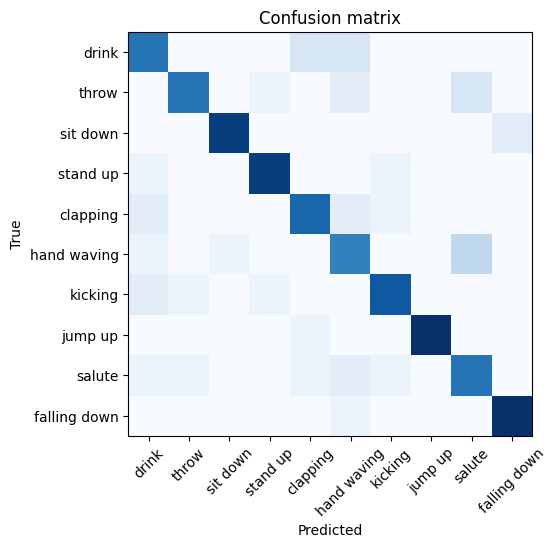

# Test Accuracy: 80.000[%]


In [ ]:
# Evaluate model
model.eval()

correct = 0
confusion_matrix = np.zeros((10, 10))
with torch.no_grad():
  for batch_idx, (data, label) in enumerate(data_loader['test']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

    for l, p in zip(label.view(-1), predict.view(-1)):
      confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = ['drink', 'throw', 'sit down', 'stand up', 'clapping', 'hand waving', 'kicking', 'jump up', 'salute', 'falling down']
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


print('# Test Accuracy: {:.3f}[%]'.format(100. * correct / len(data_loader['test'].dataset)))

# Exercise

To enhance the learning capabilities of our network, we have the opportunity to experiment with different graph structures for skeletal data. **While the original graph structure proposed in the relevant research paper provides a solid starting point, it is not a strict template that must be followed. This flexibility allows for creative design and experimentation with the graph structure**.

1. Customising the Graph Structure:
  * The freedom to design the graph structure opens up numerous possibilities. For instance, unconventional connections, such as linking anatomically distant joints like hands and feet, could lead to novel insights and improved recognition accuracy.
  * By deviating from the standard skeletal patterns, we can explore new ways of representing the human body and its movements in the network.

2. Exploring Innovative Designs:
  * Various innovative graph structures can be considered. This might include creating additional edges to capture less obvious but potentially informative relationships between joints, or connecting joints that are not typically adjacent in the human skeletal structure.
  * Such explorations could reveal hidden patterns in how different body parts coordinate and contribute to overall actions, which might be overlooked in traditional representations.

3. Aiming for Increased Recognition Accuracy:
  * The primary goal of customising the graph structure is to enhance the network's ability to accurately recognise a wide range of human actions. By experimenting with different configurations, we can identify which structures most effectively capture the nuances of human movement.
  * This process involves trial and error, where various configurations are tested and their performance in action recognition is meticulously evaluated.

4. Iterative Design and Evaluation:
  * Designing these graph structures is an iterative process, where each design is followed by rigorous testing and evaluation. Adjustments are made based on performance metrics, with a focus on increasing the accuracy and reliability of the action recognition system.

5. Leveraging Computational Tools:
  * To facilitate this experimental approach, computational tools and frameworks that allow easy manipulation and testing of graph structures are essential. These tools enable rapid prototyping and evaluation of different graph configurations, accelerating the discovery of optimal designs.

By adopting a flexible and experimental approach to designing the graph structure for skeletal data, we can potentially uncover more efficient and accurate methods for human action recognition. This innovative process could lead to significant advancements in the field, pushing the boundaries of what is currently achievable with standard skeletal graph representations.

Therefore, the assignment for this session is to propose a graph structure that could obtain better results for the available dataset. Explain all the experiments carried out and the results obtained in each case. Explain, in each case, the reason for that approach.

For instance, a preprocessing method to normalise skeletons to scale and rotation is proposed in Section 3.1 of Climent-Perez, P., & Florez-Revuelta, F. (2021). [Improved action recognition with separable spatio-temporal attention using alternative skeletal and video pre-processing](https://www.mdpi.com/1424-8220/21/3/1005). Sensors, 21(3), 1005.

Another potential approach would be to use an evolutionary algorithm as a wrapper of the ST-GCN to determine the connectivity between joints or even the joints that should be considered. See Chaaraoui, A. A., Padilla-López, J. R., Climent-Pérez, P., & Flórez-Revuelta, F. (2014). [Evolutionary joint selection to improve human action recognition with RGB-D devices](https://www.sciencedirect.com/science/article/pii/S0957417413006210). Expert systems with applications, 41(3), 786-794.

But, this is up to you how you would decide how to improve the results, either by modifying the inputs or modifying the network architecture.

You can change the graph structure by changing neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)] in class Graph.

The joints and joint numbers are as follows:

<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_skeleton.png?raw=true' width=30%>

### Apartado 1: experimentar con la Estructura del Grafo
 Redefinición de la clase graph añadiendo nuevas conexiones, lo primero que voy a hacer va a ser añadir 4 nuevas conexiones para ver si podemos mejorar el accuracy del 80% que tenemos del entrenamiento anterior, las cuatro nuevas conexiones serán entre las manos y los pies, y los hombros y la cabeza. Ya que me parecen conexiones lógicas y que podrían ayudar al modelo a detectar mejor acciones como lanzar y beber  (4, 5), (4, 9), (22, 16), (24, 20)

In [ ]:
class Graph():
  def __init__(self, hop_size):
    # Declare an edge array. As a set, declare one edge as an element like {{start point, end point}, {start point, end point}, {start point, end point}...}.
    self.get_edge()

    # hop: Connects joints that are several hops apart.
    # For example, if hop=2, the wrist is connected not only to the elbow but also to the shoulder.
    self.hop_size = hop_size
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    # Create an adjacency matrix. Here, create an adjacency matrix for each number of hops.
    # When hop is 2, three adjacency matrices are created: 0hop, 1hop, and 2hop.
    self.get_adjacency()

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # ループ
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12), (4, 5), (4, 9), (22, 16), (24, 20)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

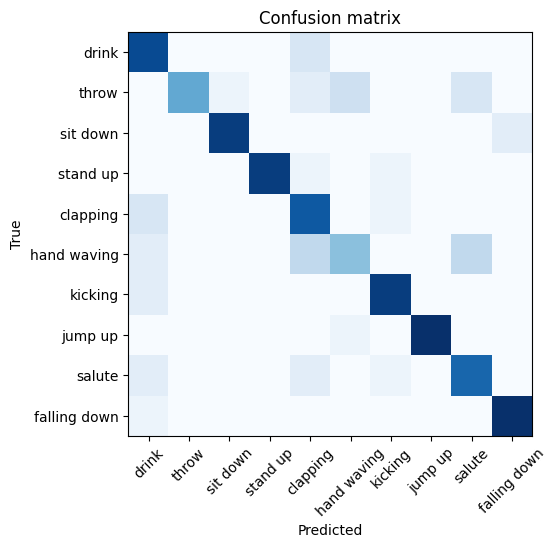
Precision del 80%

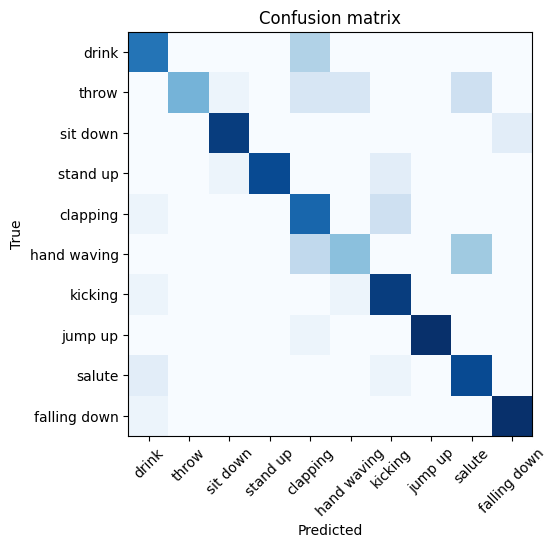
Nueva precisión del 77%



Con estas nuevas conexiones por muy lógicas que parecieran el modelo confunde con mayor facilidad ciertas clases, como por ejemplo beber y levantarse

### Apartado 2: Explorar Diseños Innovadores

Ahora voy a moficar las conexiones anteriormente hechas cambiando las articulaciones conectadas conectando las manos (7 y 11) con los pies (20 y 16), luego conectaremos los hombros con las caderas que podrían estar conectados durante una acción de saltar o correr.

In [ ]:
class Graph():
  def __init__(self, hop_size):
    # Declare an edge array. As a set, declare one edge as an element like {{start point, end point}, {start point, end point}, {start point, end point}...}.
    self.get_edge()

    # hop: Connects joints that are several hops apart.
    # For example, if hop=2, the wrist is connected not only to the elbow but also to the shoulder.
    self.hop_size = hop_size
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    # Create an adjacency matrix. Here, create an adjacency matrix for each number of hops.
    # When hop is 2, three adjacency matrices are created: 0hop, 1hop, and 2hop.
    self.get_adjacency()

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # ループ
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12), (7, 16), (11, 20), (9, 18), (4, 14)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

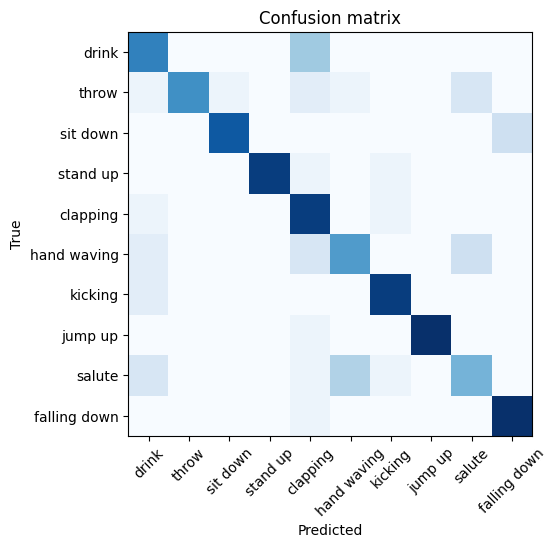


 la inclusión de conexiones entre extremidades que se pueden alejar en gran medida (como las manos y los pies) aumenta la confusión del modelo, esto podría deberse a varias razones: complejidad de movimiento, ruido en las características, sobreparametrización ( Aumentar el número de conexiones en el grafo también puede llevar a un modelo con demasiados parámetros, lo cual puede resultar en un sobreajuste a los datos de entrenamiento y una generalización pobre a nuevos datos.)

### Apartado 3, 4, 5

Lo que vamos a realizar ahora es un proceso iterativo para buscar la mejor ordenacion de nodos para buscar el mejor modelo, para ello redefiniremos las clases del Graph y las del modelo ST_GCN

In [36]:
class Graph2():
    def __init__(self, hop_size, edges=None):
        self.num_node = 25
        if edges is None:  # Si no se proporcionan aristas, usa la configuración predeterminada
            self.edges = self.define_default_edges()
        else:
            self.edges = edges  # Permite la personalización de aristas
        self.hop_size = hop_size
        self.get_edge()
        self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)
        self.get_adjacency()

    def define_default_edges(self):
        return  [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]

    def get_edge(self):
        self_link = [(i, i) for i in range(self.num_node)]  # Autoconexiones
        neighbor_link = [(i - 1, j - 1) for (i, j) in self.edges]  # Ajusta los índices a base cero
        self.edge = self_link + neighbor_link  # Combina autoconexiones y aristas personalizadas

    def get_adjacency(self):
      valid_hop = range(0, self.hop_size + 1, 1)
      adjacency = np.zeros((self.num_node, self.num_node))
      for hop in valid_hop:
          adjacency[self.hop_dis == hop] = 1
      normalize_adjacency = self.normalize_digraph(adjacency)
      A = np.zeros((len(valid_hop), self.num_node, self.num_node))
      for i, hop in enumerate(valid_hop):
          A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
      self.A = A

    def get_hop_distance(self, num_node, edge, hop_size):
      A = np.zeros((num_node, num_node))
      for i, j in edge:
          A[j, i] = 1
          A[i, j] = 1
      hop_dis = np.zeros((num_node, num_node)) + np.inf
      transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
      arrive_mat = (np.stack(transfer_mat) > 0)
      for d in range(hop_size, -1, -1):
          hop_dis[arrive_mat[d]] = d
      return hop_dis

    def normalize_digraph(self, A):
      Dl = np.sum(A, 0)
      num_node = A.shape[0]
      Dn = np.zeros((num_node, num_node))
      for i in range(num_node):
          if Dl[i] > 0:
              Dn[i, i] = Dl[i]**(-1)
      DAD = np.dot(A, Dn)
      return DAD



In [37]:
class ST_GCN2(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size, graph):
    super().__init__()
    # Create graph
    graph = graph
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()

    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1])

    # STGC_blocks
    self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size)
    self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node
    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

   Genera una lista de tuplas que representan aristas entre nodos en un grafo.La función asegura que cada variación tenga al menos `min_size` aristas.
    

In [38]:
import random

def generate_edges_variation(num_nodes=25, min_size=11):
    edges = []
    available_nodes = list(range(1, num_nodes + 1))  # Los nodos disponibles para conectar

    # Asegura una estructura mínimamente conectada al crear un camino que une todos los nodos
    random.shuffle(available_nodes)  # Aleatoriza el orden de los nodos
    for i in range(num_nodes - 1):
        # Conecta cada nodo con el siguiente en la lista aleatorizada para asegurar conectividad
        edges.append((available_nodes[i], available_nodes[i + 1]))

    # Añade aristas adicionales de forma aleatoria hasta alcanzar el tamaño mínimo
    while len(edges) < min_size:
        # Escoge dos nodos aleatorios
        n1, n2 = random.sample(available_nodes, 2)
        new_edge = (n1, n2)

        # Asegura que la arista no sea un duplicado y que no conecte un nodo consigo mismo
        if new_edge not in edges and n1 != n2:
            edges.append(new_edge)

    return edges

print(generate_edges_variation())

[(13, 25), (25, 6), (6, 15), (15, 21), (21, 22), (22, 11), (11, 14), (14, 1), (1, 18), (18, 4), (4, 12), (12, 8), (8, 7), (7, 24), (24, 20), (20, 16), (16, 9), (9, 10), (10, 19), (19, 2), (2, 17), (17, 3), (3, 5), (5, 23)]


In [39]:
import torch

def train_model(model, criterion, data_loader, num_epochs=50, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.to(device)
    model.train()  # Pone el modelo en modo de entrenamiento

    for epoch in range(1, num_epochs + 1):
        correct = 0
        sum_loss = 0

        for batch_idx, (data, label) in enumerate(data_loader['train']):
            data, label = data.to(device), label.to(device)

            # Optimizer
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

            # Forward pass
            output = model(data)

            # Calcula la pérdida
            loss = criterion(output, label)

            # Backward pass y optimiza
            loss.backward()
            optimizer.step()

            # Suma la pérdida y calcula la precisión
            sum_loss += loss.item()
            _, predict = torch.max(output.data, 1)
            correct += (predict == label).sum().item()

        # Imprime métricas de entrenamiento
        print(f'# Epoch: {epoch} | Loss: {sum_loss / len(data_loader["train"].dataset):.4f} | Accuracy: {100. * correct / len(data_loader["train"].dataset):.4f}%')

    return model  # Retorna el modelo entrenado


  Evalúa el modelo proporcionado utilizando el cargador de datos de prueba especificado.
  Calcula la precisión total del modelo y genera una matriz de confusión.



In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    model.eval()
    model.to(device)
    correct = 0
    confusion_matrix = np.zeros((10, 10))

    with torch.no_grad():
        for data, label in data_loader['test']:
            data, label = data.to(device), label.to(device)
            output = model(data)
            _, predict = torch.max(output.data, 1)
            correct += (predict == label).sum().item()

            for l, p in zip(label.view(-1), predict.view(-1)):
                confusion_matrix[l.long(), p.long()] += 1

    # Normaliza la matriz de confusión
    for i in range(len(confusion_matrix)):
        confusion_matrix[i] = 100 * (confusion_matrix[i] / np.sum(confusion_matrix[i]))

    accuracy = 100. * correct / len(data_loader['test'].dataset)

    # Visualización de la matriz de confusión
    classes = ['drink', 'throw', 'sit down', 'stand up', 'clapping', 'hand waving', 'kicking', 'jump up', 'salute', 'falling down']
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(f'# Test Accuracy: {accuracy:.3f}[%]')

    return accuracy, confusion_matrix


# Epoch: 1 | Loss: 0.0363 | Accuracy: 15.4500%


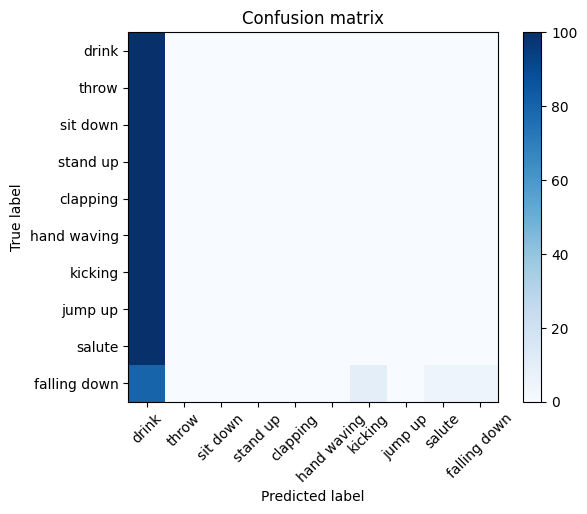

# Test Accuracy: 10.500[%]
# Epoch: 1 | Loss: 0.0352 | Accuracy: 20.0500%


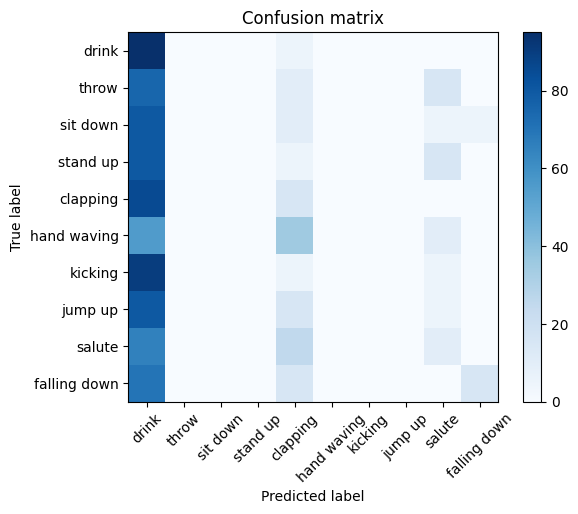

# Test Accuracy: 13.500[%]


KeyboardInterrupt: 

In [43]:
from matplotlib.colors import ListedColormap
import random


best_accuracy = 0.0
best_model = None
best_confusion_matrix = None
best_model_idx = -1

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Prepare dataset
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True,)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)


for model_idx in range(10):
    # Generar una variación de aristas
    edges_variation = generate_edges_variation(min_size=random.randint(1, 100))

    # Instanciar el modelo con la variación actual de aristas
    graph = Graph2(hop_size=2, edges=edges_variation)
    model = ST_GCN2(num_classes=10, in_channels=3, t_kernel_size=9, hop_size=2, graph=graph)

    # Entrenar el modelo (implementa tu lógica de entrenamiento aquí)
    trained_model = train_model(model = model, criterion=criterion, data_loader = data_loader)  # Esta función debe implementarse

    # Evaluar el modelo
    accuracy, confusion_matrix = evaluate_model(model= trained_model, data_loader=data_loader)

    # Guardar el modelo si supera al mejor actual
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_confusion_matrix = confusion_matrix
        best_model_idx = model_idx